In [12]:
import gpytorch
import torch
from matplotlib import pyplot as plt
import numpy as np

In [13]:
train_x = torch.linspace(-10,10, 100)
train_y = torch.sin(train_x) + np.sqrt(0.05)*torch.randn(100)

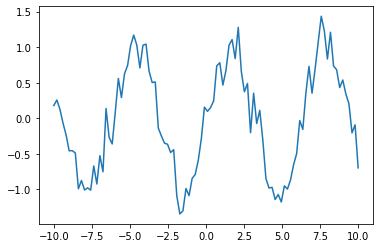

In [9]:
plt.plot(train_x, train_y)

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [17]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.000   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.964   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.926   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.890   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.855   lengthscale: 0.911   noise: 0.513
Iter 6/50 - Loss: 0.820   lengthscale: 0.970   noise: 0.474
Iter 7/50 - Loss: 0.786   lengthscale: 1.030   noise: 0.437
Iter 8/50 - Loss: 0.753   lengthscale: 1.091   noise: 0.403
Iter 9/50 - Loss: 0.721   lengthscale: 1.150   noise: 0.370
Iter 10/50 - Loss: 0.690   lengthscale: 1.208   noise: 0.340
Iter 11/50 - Loss: 0.659   lengthscale: 1.263   noise: 0.312
Iter 12/50 - Loss: 0.629   lengthscale: 1.313   noise: 0.286
Iter 13/50 - Loss: 0.598   lengthscale: 1.358   noise: 0.262
Iter 14/50 - Loss: 0.568   lengthscale: 1.395   noise: 0.239
Iter 15/50 - Loss: 0.538   lengthscale: 1.425   noise: 0.219
Iter 16/50 - Loss: 0.508   lengthscale: 1.448   noise: 0.200
Iter 17/50 - Loss: 0.478   length